In [ ]:
import os
import numpy as np
import pandas as pd
import csv
import time

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Code")

import cleaning_tweets as ct
from cleaning_tweets import getidx, preprocess, dealing_topics, generate_aspects, clean_aspects

os.chdir("/content/drive/MyDrive/Data")

# BERT
!pip install transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch import nn

# Gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import * 

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [ ]:
df = pd.read_excel('./topic/trainset_evaluation.xlsx')
df.info()

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

## Evaluate Sentiment Analysis

In [ ]:
def get_senti_labels(content, max_len, tokenizer, pt_model):
    pt_batch = tokenizer(content,
                                        padding=True,
                                        truncation=True,
                                        max_length=max_len,
                                        return_tensors="pt"
                                        )
    pt_outputs = pt_model(**pt_batch)
    pt_predictions = nn.functional.softmax(pt_outputs.logits, dim=-1) 
    _, label_pred = torch.max(pt_predictions, 1)
    # loss = pt_outputs.loss
    lable_idx = int(label_pred.detach().numpy())
    score_pred = float(pt_predictions.max().detach().numpy())
    lst = [lable_idx]
    lst.append(score_pred)
    return lst

### BERT

In [ ]:
model_name_bert = "distilbert-base-uncased-finetuned-sst-2-english"
pt_model_bert = AutoModelForSequenceClassification.from_pretrained(model_name_bert)
tokenizer_bert = AutoTokenizer.from_pretrained(model_name_bert)
# classifier_bert = pipeline('sentiment-analysis', model=pt_model_bert, tokenizer=tokenizer_bert)
labels = ['negative', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


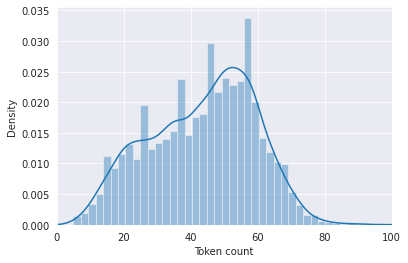

In [ ]:
df_all = pd.read_csv('textid.csv', nrows=10000, engine='python', encoding = 'utf-8-sig', dtype=str, header = None)
df_all.columns = ['text', 'text_id']
token_lens = []

for txt in df_all['text']:
    tokens = tokenizer_bert.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

sns.distplot(token_lens);
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [ ]:
df1 = df.copy()
df1.dropna(subset=['st_labels'], axis=0, how='any', inplace=True)
df1 = df1[df1['st_labels']!=0]
df1.reset_index(inplace=True, drop=True)

max_len = 128

start_time = time.time()
df1.loc[:, "st_labels_nm"] = df1['st_labels'].apply(lambda r: labels[0] if int(r)==-1 else labels[1])
df1.loc[:, "st_result"] = df1["text"].astype(str).apply(lambda r:get_senti_labels(r, max_len, tokenizer_bert, pt_model_bert))
df1.loc[:, 'pred_st_labels'] = df1['st_result'].apply(lambda r: r[0])
df1.loc[:, 'pred_st_scores'] = df1['st_result'].apply(lambda r: r[1])
df1.loc[:, 'pred_st_labels_nm'] = df1['pred_st_labels'].apply(lambda r: labels[int(r)])
print(f"-cost time: {(time.time()-start_time)} seconds")

train_labels = list(df1['st_labels_nm'])
train_pred = list(df1['pred_st_labels_nm'])
acc = accuracy_score(train_labels, train_pred)
rec  = recall_score(train_labels, train_pred, average='macro')
pre = precision_score(train_labels, train_pred, average='macro')
f1 = f1_score(train_labels, train_pred, average='macro')
print(f"Accuracy: {acc}; \nRecall: {rec}; \nPrecision: {pre}; \nF1Score: {f1}")

### RoBERTa

In [ ]:
task = 'sentiment'
model_name_roberta = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer_roberta = AutoTokenizer.from_pretrained(model_name_roberta)
pt_model_roberta = AutoModelForSequenceClassification.from_pretrained(model_name_roberta)
labels = ['negative', 'neutral', 'positive']

In [ ]:
df2 = df.copy()
df2.dropna(subset=['st_labels'], axis=0, how='any', inplace=True)
df2 = df2[df2['st_labels']!=0]
df2.reset_index(inplace=True, drop=True)

max_len = 128

start_time = time.time()
df2.loc[:, "st_labels_nm"] = df2['st_labels'].apply(lambda r: labels[0] if int(r)==-1 else (labels[2] if int(r)==1 else labels[1]))
df2.loc[:, "st_result"] = df2["text"].astype(str).apply(lambda r:get_senti_labels(r, max_len, , tokenizer_roberta, pt_model_roberta))
df2.loc[:, 'pred_st_labels'] = df2['st_result'].apply(lambda r: r[0])
df2.loc[:, 'pred_st_scores'] = df2['st_result'].apply(lambda r: r[1])
df2.loc[:, 'pred_st_labels_nm'] = df2['pred_st_labels'].apply(lambda r: labels[int(r)])
print(f"-cost time: {(time.time()-start_time)} seconds")

train_labels = list(df2['st_labels_nm'])
train_pred = list(df2['pred_st_labels_nm'])
acc = accuracy_score(train_labels, train_pred)
rec  = recall_score(train_labels, train_pred, average='macro')
pre = precision_score(train_labels, train_pred, average='macro')
f1 = f1_score(train_labels, train_pred, average='macro')
print(f"Accuracy: {acc}; \nRecall: {rec}; \nPrecision: {pre}; \nF1Score: {f1}")

### Comparison

In [ ]:
def test(max_length, keep0=0, tokenizer, pt_model):
    ct_lst = []
    acc_lst = []
    rec_lst = []
    pre_lst = []
    f1_lst = []
    for ml in range(10, max_length+1):
        df1 = df.copy()
        df1.dropna(subset=['st_labels'], axis=0, how='any', inplace=True)
        if keep0 == 0:
            labels = ['negative', 'positive']
            df1 = df1[df1['st_labels']!=0]
            df1.reset_index(inplace=True, drop=True)
            df1.loc[:, "st_labels_nm"] = df1['st_labels'].apply(lambda r: labels[0] if int(r)==-1 else labels[1])
        else:
            labels = ['negative', 'neutral', 'positive']
            df1.loc[:, "st_labels_nm"] = df1['st_labels'].apply(lambda r: labels[0] if int(r)==-1 else (labels[2] if int(r)==1 else labels[1]))
        
        start_time = time.time() 
        df1.loc[:, "st_result"] = df1["text"].astype(str).apply(lambda r:get_senti_labels(r, ml, tokenizer, pt_model))
        df1.loc[:, 'pred_st_labels'] = df1['st_result'].apply(lambda r: r[0])
        df1.loc[:, 'pred_st_scores'] = df1['st_result'].apply(lambda r: r[1])
        df1.loc[:, 'pred_st_labels_nm'] = df1['pred_st_labels'].apply(lambda r: labels[int(r)])
        cost_time  = time.time()-start_time
        ct_lst.append(cost_time)
        train_labels = list(df1['st_labels_nm'])
        train_pred = list(df1['pred_st_labels_nm'])
        acc = accuracy_score(train_labels, train_pred)
        rec  = recall_score(train_labels, train_pred, average='macro')
        pre = precision_score(train_labels, train_pred, average='macro')
        f1 = f1_score(train_labels, train_pred, average='macro')
        # print(f"Accuracy: {acc}; \nRecall: {rec}; \nPrecision: {pre}; \nF1Score: {f1}")
        acc_lst.append(acc)
        rec_lst.append(rec)
        pre_lst.append(pre)
        f1_lst.append(f1)
    
    return acc_lst, rec_lst, pre_lst, f1_lst, ct_lst

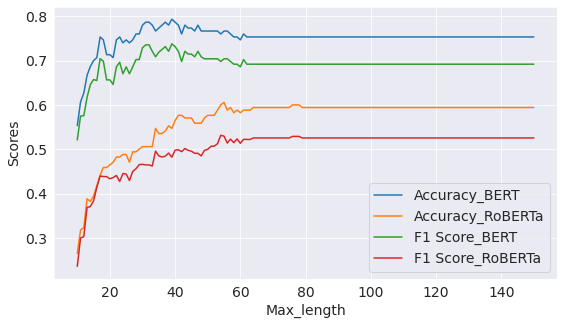

In [ ]:
#BERT
acc_lst, rec_lst, pre_lst, f1_lst, ct_lst = test(150, 0, tokenizer_bert, pt_model_bert)

max_length = 150
plt.plot(range(10, max_length+1), acc_lst, label='Accuracy')
plt.plot(range(10, max_length+1), rec_lst, label='Recall')
plt.plot(range(10, max_length+1), pre_lst, label='Precision')
plt.plot(range(10, max_length+1), f1_lst, label='F1 Score')
plt.legend()
plt.xlabel('Max_length');
plt.ylabel('Scores');

# RoBERTa
acc_lst2, rec_lst2, pre_lst2, f1_lst2, ct_lst2 = test(150, 1, tokenizer_roberta, pt_model_roberta)

max_length = 150
plt.plot(range(10, max_length+1), acc_lst, label='Accuracy_BERT')
plt.plot(range(10, max_length+1), acc_lst2, label='Accuracy_RoBERTa')
plt.plot(range(10, max_length+1), f1_lst, label='F1 Score_BERT')
plt.plot(range(10, max_length+1), f1_lst2, label='F1 Score_RoBERTa')
plt.legend()
plt.xlabel('Max_length');
plt.ylabel('Scores');

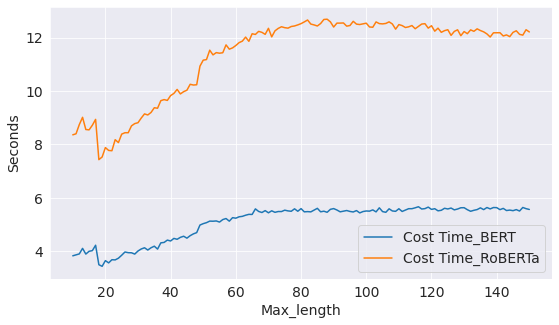

In [ ]:
plt.plot(range(10, max_length+1), ct_lst, label='Cost Time_BERT')
plt.plot(range(10, max_length+1), ct_lst2, label='Cost Time_RoBERTa')
plt.legend()
plt.xlabel('Max_length');
plt.ylabel('Seconds');

## Evaluate Aspects

In [ ]:
topicidx_to_aspect, aspect_to_idx, idx_to_aspect = getidx()

### LDA

In [ ]:
def predlst(content):
    if pd.isna(content):
        return np.nan
    else:
        lst = list(eval(content))
        pre_lst = [str(apidx) for apidx, score in lst]
    return pre_lst

In [ ]:
df2 = df.copy()
df2.dropna(subset=['st_labels'], axis=0, how='any', inplace=True)
df2.dropna(subset=['aspects'], axis=0, how='any', inplace=True)
df2 = df2[df2['st_labels']!=0]
df2.reset_index(inplace=True, drop=True)
df2.loc[:, "aspects_idx"] = df2["aspects"].apply(lambda r: str(aspect_to_idx[r.strip()]) if pd.isna(r)==False else r)

start_time = time.time()
df2.loc[:, "preprocess_text"] = df2["text"].astype(str).apply(preprocess)
df2.loc[:, "topics"] = df2["preprocess_text"].apply(dealing_topics)
df2.loc[:, "aspect"] = df2["topics"].apply(generate_aspects)
df2.loc[:, "aspects_pred"] = df2["aspect"].astype(str).apply(clean_aspects)
df2.drop(labels=["preprocess_text", "topics", "aspect"], axis=1, inplace=True) 
print(time.time() - start_time)


1.7670323848724365


In [ ]:
df2.loc[:, 'acc_ap'] = df2.apply(lambda r: 1 if r['aspects_idx'] in predlst(r['aspects_pred']) else 0, axis=1)
acc = len(df2[df2['acc_ap']==1])/df2.shape[0]
print(f"Accuracy: {acc}")

Accuracy: 0.5066666666666667


### zero-shot

In [ ]:
classifier = pipeline("zero-shot-classification")

In [ ]:
def get_aspects(text):
    aspect_results = classifier(text, aspect_labels, multi_label=True)
    aspect_lst = []
    for i in range(len(aspect_labels)):
        if aspect_results['scores'][i] >= 0.1:
            aspect_lst.append(aspect_results['labels'][i])
        else:
            continue
    aspect_idx_lst = [aspect_to_idx[i] for i in aspect_lst]
    return aspect_idx_lst[:3]

In [ ]:
df0 = df.copy()
df0 = df0[df0['st_labels']!=0]
aspect_labels = ["china", "government", "information", "lockdown", "protective measures", \
                            "quarantine", "spread", "support measures", "treatment"]

df0.loc[:, "aspects_idx"] = df0["aspects"].apply(lambda r: str(aspect_to_idx[r.strip()]) if pd.isna(r)==False else r)
start_time = time.time()
df0.loc[:, 'zero_aspects'] = df0['text'].apply(get_aspects)
print(time.time() - start_time)

313.85648941993713


In [ ]:
df0.loc[:, 'acc_ap'] = df0.apply(lambda r: 1 if int(r['aspects_idx']) in r['zero_aspects'] else 0, axis=1)
acc = len(df0[df0['acc_ap']==1])/df0.shape[0]
print(f"Accuracy: {acc}")

Accuracy: 0.5666666666666667


# Evaluate ABSA

In [ ]:
df3 = pd.concat([df1.iloc[:, [0, 3, 4, 8]], df2.iloc[:, [4, 5, 6]]], axis=1)
df3.loc[:, 'acc_st'] = df3.apply(lambda r: 1 if r['st_labels_nm']==r['pred_st_labels_nm'] else 0, axis=1)
df3.loc[:, 'acc'] = df3.apply(lambda r: 1 if r['acc_ap']==1 and r['acc_st']==1 else 0, axis=1)
print(len(df3[df3['acc']==1])/df3.shape[0])

0.37333333333333335
